In [3]:
import pandas as pd

pd.set_option('display.max_colwidth', 800)

In [7]:
columns = ['title_en', 'description_en', 'date_released']
catalog = pd.read_csv(r'.\data\canada-open-data\inventory.csv', usecols=columns)
catalog.dropna(subset=['description_en'], inplace=True)
catalog

,title_en,description_en,date_released
0,The AAFC Productivity Account for Canadian Agriculture,"The AAFC Productivity Account for Canadian agriculture is an annual time-series database, covering the years 1961-2011, that is comprised of price index and constant dollar implicit quantity series for gross output and input aggregates. The data are defined at the national level only – i.e. for the whole of Canada. These data are used to estimate a total factor productivity (TFP) index for Canadian agriculture, which is the ratio of total gross output to total input, where both output and input are constant dollar implicit quantities. Average growth in the TFP index, referred to as TFP growth, can be estimated using a variety of methods; the growth rate reported in AAFC publications is estimated using OLS.\n\nFurther documentation provided in AAFC_PACA.odt",2018-08-10
1,Swift Current Water Chemistry - Long Term Tillage Study - 1962-2011,"The Swift current water quantity and quality is an annual time-series database covering the period of 1962-2011. This database contains datasets for annual runoff volume, peak flow rates, water quality attributes, snow water equivalent and soil moisture from an edge of field study conducted at Swift Current, SK.",2018-11-23
2,Minor Use Pesticides Program Project Status by Crop,"The Pest Management Centre’s (PMC) Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\n\nThis is a complete list of PMC’s projects with their statuses. For those projects with the status D.3.2 Review Complete, please check with the pesti...",2018-12-14
3,Minor Use Pesticides Program Submission Status by Fiscal Year,"The Pest Management Centre Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\n\nThis list of submissions to PMRA is the result of PMC’s work and is for information purposes only. To find out if the pesticide can be used, please check wi...",2018-12-14
4,Minor Use Pesticides Program Trial Statistics by Year by Discipline,The following table provides information pertaining to the minor use pesticide study and/or trial status. These studies/trials are managed by the Pest management Center of the AAFC. This table is updated monthly.,2018-12-14
...,...,...,...
10811,Value of business expenditures in research and development (BERD) by firm receiving WD program funding (in $),"Business Expenditures in Research and Development (BERD) – expenditures by private firms on research and development. It includes creative work undertaken on a systematic basis in order to increase the stock of knowledge, and the use of this knowledge to devise new applications. R&D covers three activities: basic research, applied research, and experimental development.",2018-10-31
10812,Percentage of professional jobs (including science & technology) in western Canada,"Professional, science and technology-related jobs – Based on an OECD definition o

In [11]:
def text_to_tokens(text):
    text = text.lower()
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    return tokens

In [12]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
dataset_descriptions = catalog.description_en.apply(text_to_tokens)
dataset_descriptions

0                                                                                                                                [aafc, productivity, account, canadian, agriculture, annual, time, series, database, covering, years, comprised, price, index, constant, dollar, implicit, quantity, series, gross, output, input, aggregates, data, defined, national, level, canada, data, estimate, total, factor, productivity, tfp, index, canadian, agriculture, ratio, total, gross, output, total, input, output, input, constant, dollar, implicit, quantities, average, growth, tfp, index, referred, tfp, growth, estimated, variety, methods, growth, rate, reported, aafc, publications, estimated, ols, documentation, provided, aafc_paca, odt]
1                                                                                                                                                                                                                                                                       

In [13]:
import gensim
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string

dictionary = gensim.corpora.Dictionary(dataset_descriptions)
corpus = [dictionary.doc2bow(text) for text in dataset_descriptions]

In [14]:
for i in range(0, 20):
    print(i, dictionary[i])

0 aafc
1 aafc_paca
2 account
3 aggregates
4 agriculture
5 annual
6 average
7 canada
8 canadian
9 comprised
10 constant
11 covering
12 data
13 database
14 defined
15 documentation
16 dollar
17 estimate
18 estimated
19 factor


In [15]:
VECTOR_SIZE = 50
lda_model:LdaModel = LdaModel(corpus,
                              num_topics=VECTOR_SIZE,
                              passes=4)

lda_model.num_topics

50

In [16]:
text = catalog.description_en[0]
tokens = text_to_tokens(text)
bag_of_words = dictionary.doc2bow(tokens)
pd.DataFrame(lda_model[bag_of_words],
             columns=['Topic', 'Relevance']).set_index('Topic')

,Relevance
Topic,
0,0.033595
2,0.017586
3,0.095969
7,0.180248
12,0.017861
14,0.044946
15,0.019487
19,0.050257
32,0.059672


In [17]:
def topic_vector(topic_model:LdaModel, text:str):
    processed_text = text_to_tokens(text)
    bag_of_words = dictionary.doc2bow(processed_text)
    fingerprint = [0] * topic_model.num_topics
    for topic, prob in topic_model[bag_of_words]:
        fingerprint[topic] = prob
    return fingerprint

In [29]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from IPython.display import display

style.use('fivethirtyeight')

VECTOR_SIZE = 50

def show_fingerprint(topic_model, text):
    display(text)
    vector = topic_vector(topic_model, text)
    plt.figure(figsize=(14,2))
    ax = plt.bar(range(len(vector)),
                 vector,
                 0.25,
                 linewidth=1)
    plt.ylim(top=0.5)
    plt.tick_params(axis='both',
                    left=False,
                    top=False,
                    labelleft=False)
    plt.grid(False)

'The AAFC Productivity Account for Canadian agriculture is an annual time-series database, covering the years 1961-2011, that is comprised of price index and constant dollar implicit quantity series for gross output and input aggregates. The data are defined at the national level only – i.e. for the whole of Canada. These data are used to estimate a total factor productivity (TFP) index for Canadian agriculture, which is the ratio of total gross output to total input, where both output and input are constant dollar implicit quantities. Average growth in the TFP index, referred to as TFP growth, can be estimated using a variety of methods; the growth rate reported in AAFC publications is estimated using OLS.\n\nFurther documentation provided in AAFC_PACA.odt'

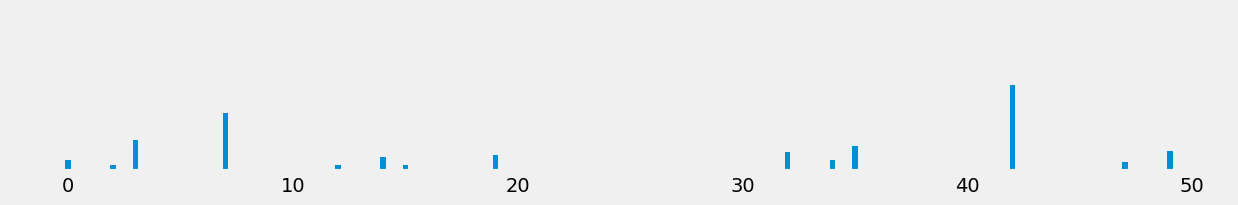

In [30]:
show_fingerprint(lda_model, catalog.description_en[0])

"The Pest Management Centre’s (PMC) Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\n\nThis is a complete list of PMC’s projects with their statuses. For those projects with the status D.3.2 Review Complete, please check with the pesticide manufacturer or visit PMRA's pesticide label database to find out if the pesticide is ready for use. "

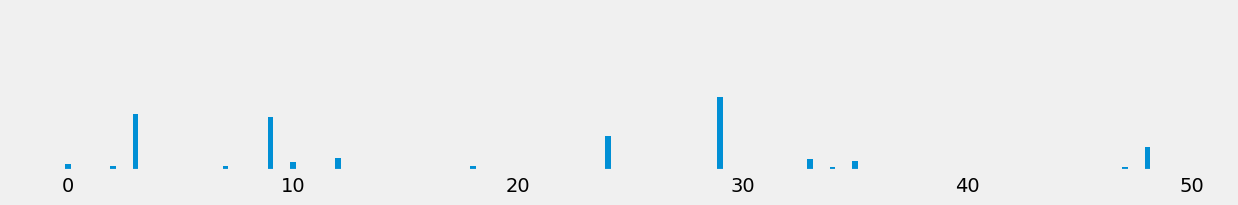

In [31]:
show_fingerprint(lda_model, catalog.description_en[2])